### Visualization notebook, Now uses _mkB functions

In [22]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from config import CONFIG_mkB
from hospital_model import hospital_model

### 20 independent seeds, comparing three configurations

In [23]:
# --- simulate 20 independent samples, and compare the facility configurations for all 20 ---
results_all = [[],[],[]]

# loop over configs
for seed in range(20): # use numbers 1-20 as the seeds for simplicity.
    results_for_this_seed = []
    conf = copy.deepcopy(CONFIG_mkB)
    conf['seed'] = seed # initializing hospital_model also resets the random generator with this seed.
    conf['total'] = [5,1,5]
    for layout in [[3,1,4],[3,1,5],[4,1,5]]: # facility configs to be compared
        conf['staffed'] = layout
        hospital = hospital_model(conf)
        hospital.run_for(100) # warm up from sim init
        # clear the result so warm-up is not included
        hospital.results['patient_flow'] = []
        # hospital.results['patient_counts'] = [0,0,0,0] # do not reset, only matters at end of sim.
        hospital.results['total_active'] = [0,0,0]
        hospital.results['util_active'] = [0,0,0]
        hospital.results['snapshots'] = []
        hospital.results['or_time_blocked'] = 0
        hospital.run_for(1000) # actual simulation run
        results_for_this_seed.append(hospital.results) # per-config results
    results_all[0].append(results_for_this_seed[0])
    results_all[1].append(results_for_this_seed[1])
    results_all[2].append(results_for_this_seed[2])

# result analysis:
print('Operating room was stuck waiting for a recovery spot _ % of the time:')
or_blocked_percentage = []
or_blocked_time = 0
for a in results_all[0]:
    or_blocked_percentage.append([s['queues'][2] for s in a['snapshots']])
    or_blocked_time += a['or_time_blocked']
print('3-1-4: ', sum([len([b for b in a if b != 0]) for a in or_blocked_percentage]) / sum([len(a) for a in or_blocked_percentage]) * 100)
or_blocked_percentage = []
for a in results_all[1]:
    or_blocked_percentage.append([s['queues'][2] for s in a['snapshots']])
print('3-1-5: ', sum([len([b for b in a if b != 0]) for a in or_blocked_percentage]) / sum([len(a) for a in or_blocked_percentage]) * 100)
or_blocked_percentage = []
for a in results_all[2]:
    or_blocked_percentage.append([s['queues'][2] for s in a['snapshots']])
print('4-1-4: ', sum([len([b for b in a if b != 0]) for a in or_blocked_percentage]) / sum([len(a) for a in or_blocked_percentage]) * 100)

print('All recovery rooms were occupied for _ % of the time')
print('3-1-4: ', len([a['patient_counts'][3] for a in results_all[0] if a['patient_counts'][3] == 5]) 
      / len([a['patient_counts'][3] for a in results_all[0]]))
print('3-1-5: ', len([a['patient_counts'][3] for a in results_all[1] if a['patient_counts'][3] == 5]) 
      / len([a['patient_counts'][3] for a in results_all[1]]))
print('4-1-5: ', len([a['patient_counts'][3] for a in results_all[2] if a['patient_counts'][3] == 5]) 
      / len([a['patient_counts'][3] for a in results_all[2]]))

Operating room was stuck waiting for a recovery spot _ % of the time:
3-1-4:  2.325
3-1-5:  0.6
4-1-4:  0.95
All recovery rooms were occupied for _ % of the time
3-1-4:  0.0
3-1-5:  0.1
4-1-5:  0.1


### Twist

In [24]:
conf = copy.deepcopy(CONFIG_mkB) # prevent side effect on default configuration
conf['seed'] = 2025
conf['total'] = [10,10,10] # increase slack capacity for demo. changes to this conf param mid-simulation may cause issues
conf['staffed'] = [3,1,2]
hospital = hospital_model(conf)
hospital.run_for(1000)
conf['means'][0] = 200 # increase patient arrival delay for demo purposes, result: total patient amount in system starts going down
hospital.run_for(1000)
conf['staffed'] = [3,1,0] # change what facilities are staffed, demo to show that OR is now fully blocked
hospital.run_for(1000)

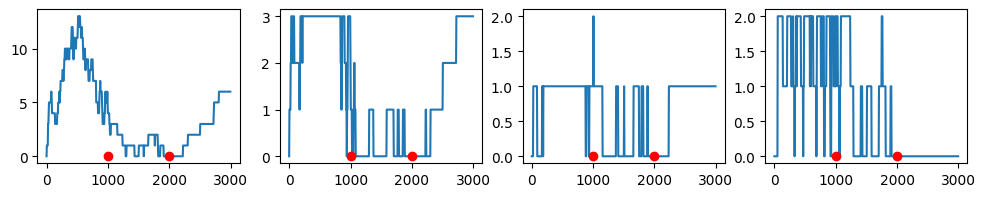

In [25]:
# visualize rooms: note spike when applying a config change.
plot_stages = len(hospital.results['snapshots'][0]['patient_counts']) # plot each metric monitored by snapshots
fig, axs = plt.subplots(figsize=(3*plot_stages,2),ncols = plot_stages)
x = [s['time'] for s in hospital.results['snapshots']] # snapshot times on x-axis
for a in range(len(axs)):
    axs[a].plot(x,[s['patient_counts'][a] for s in hospital.results['snapshots']])
    axs[a].plot([1000,2000],[0,0],'ro') # example param changes

OR utilization: 0.812%
OR blocked for 8.3% of the time
OR was waiting for REC 0.335 of the simulation


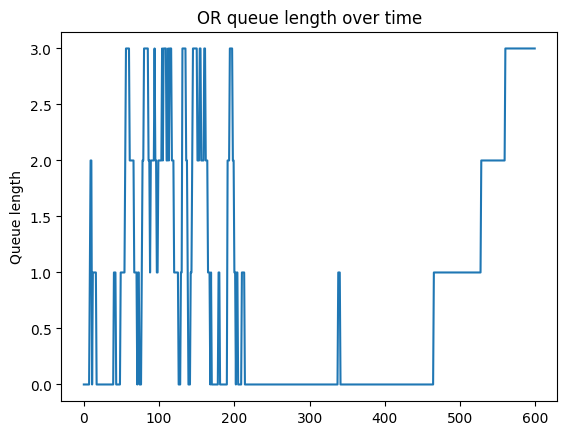

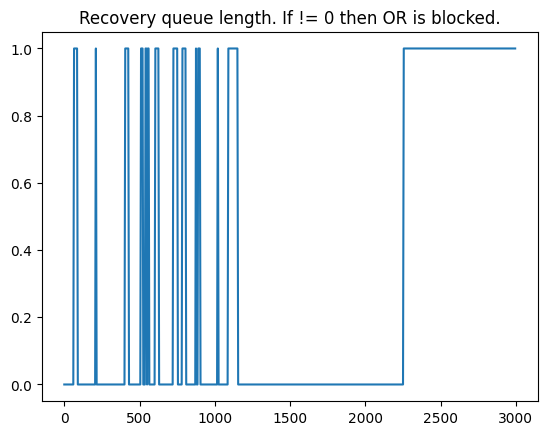

In [26]:
queue_lengths = []#list of or queue lengths
blocked_time = hospital.results["or_time_blocked"]#total or blocked time
total_time = hospital.results["snapshots"][-1]["time"]#total simulation time
for snapshot in hospital.results["snapshots"]:
    queue_lengths.append(snapshot["queues"][1])

plt.figure(0)
plt.plot(queue_lengths)

plt.title("OR queue length over time")
plt.ylabel("Queue length")

active_times = hospital.results["util_active"]
total_times  = hospital.results["total_active"]
print(f'OR utilization: {np.round(active_times[1]/total_times[1],3)}%')
print(f'OR blocked for {np.round(blocked_time/total_time,3)*100}% of the time')

# -- calculate OR block from queue lengths --
# array of each snapshots queue length in rec room. 
# note that the data is compressed to 1 and 0 to ignore overshoot caused by slack capacity.
or_blocked = [int(y['queues'][2] != 0) for y in hospital.results['snapshots']]
print('OR was waiting for REC %s of the simulation' % (sum(or_blocked) / len(or_blocked)))
plt.figure(1) # plot monitor of recovery queue
plt.title('Recovery queue length. If != 0 then OR is blocked.')
plt.plot(x, or_blocked) # check for != 0 then cast back to int for plotting

In [27]:
# --- alt. ver of 3-config comparison.
def simulate(samples,rooms):
    utilizations = []
    blocked = []
    for sample in range(samples):

        conf = copy.deepcopy(CONFIG_mkB) # prevent side effect on default configuration
        conf['seed'] = sample # all three hospital configurations use the same seed, but there is 20 different seeds total.
        conf['total'] = [10,10,10] # increase slack capacity for demo. changes to this conf param dont have effect mid-simulation
        hospital = hospital_model(conf)

        #hospital.run_for(1000)
        #conf['means'][0] = 200 # increase patient arrival delay for demo purposes
        # hospital.run_for(1000)

        conf['staffed'] = rooms # change what facilities are staffed
        #print(hospital.env.now)
        hospital.run_for(100)#warm up
        env_time = hospital.env.now #env time after warmup
        #print(env_time)
        #Resetting statsistics
        hospital.results["or_time_blocked"] = 0
        hospital.results["util_active"] = [0,0,0]
        hospital.results["total_active"] = [0,0,0]
        hospital.results["snapshots"]=[]

        hospital.run_for(1000)#actual simulation run
        active_times = hospital.results["util_active"]
        total_times  = hospital.results["total_active"]
        blocked_time = hospital.results["or_time_blocked"]

        total_time = hospital.results["snapshots"][-1]["time"] -env_time #total simulation time,simulation time at the end - warmup time
        #print(total_times)
        utilizations.append(np.round(active_times[1]/total_time,5)*100)
        blocked.append(np.round(blocked_time/total_time,3)*100)

    print(f'Statistics for {rooms[0]}p {rooms[2]}r configuration ')
    print(f'MEAN utilization: {np.round(np.mean(utilizations),3)}%')
    print(f'MEAN blocked: {np.round(np.mean(blocked),3)}%')
    print("--------------------------------")
    return utilizations,blocked
utilizations_314,blocked_314 = simulate(samples = 20,rooms=[3,1,4])
utilizations_315,blocked_315 = simulate(samples = 20,rooms=[3,1,5])
utilizations_415,blocked_415 = simulate(samples = 20,rooms=[4,1,5])

Statistics for 3p 4r configuration 
MEAN utilization: 76.07%
MEAN blocked: 2.31%
--------------------------------
Statistics for 3p 5r configuration 
MEAN utilization: 76.682%
MEAN blocked: 0.57%
--------------------------------
Statistics for 4p 5r configuration 
MEAN utilization: 78.582%
MEAN blocked: 0.975%
--------------------------------


### Finding twisted version with similar operating room utilization as non-twisted

In [28]:
conf = copy.deepcopy(CONFIG_mkB) # prevent side effect on default configuration
conf['total'] = [10,10,10]
conf['staffed'] = [3,1,2] # same for both twisted and non.
print('patients actually being treated / patients spent in op room:')

# --- non-twisted ---
hospital = hospital_model(conf)
hospital.run_for(4000)
print('no twist:', hospital.results['util_active'][1] / hospital.results['total_active'][1])

# -- twisted: electrical outage for time 1000 to 1500
hospital = hospital_model(conf)
conf['means'][0] = 45
hospital.run_for(1000)
conf['staffed'] = [0,0,0]
hospital.run_for(500)
conf['staffed'] = [3,1,2]
hospital.run_for(3500)
print('yeah twist, and arrival time distr. increased to 35: ', hospital.results['util_active'][1] / hospital.results['total_active'][1])

patients actually being treated / patients spent in op room:
no twist: 0.7384132123047674
yeah twist, and arrival time distr. increased to 35:  0.40410501750347305


### Extract OR Waiting-Time Series

In [29]:
def _extract_or_wait_series(results, conf=None, burn_in_time=0.0, clip_negative=True):
    """
    Returns a 1D numpy array of per-patient OR waiting times ordered by OR entry time.
    clip_negative:
      if True, negative values are clipped to 0.
    """
    if 'patient_flow' not in results or len(results['patient_flow']) == 0:
        raise ValueError("results does not contain non-empty 'patient_flow'.")

    flows = results['patient_flow']

    # Build rows: (or_start, prep_start)
    rows = []
    for f in flows:
        # Defensive: skip incomplete records
        if f is None or len(f) < 3:
            continue
        prep_start = f[1]
        or_start = f[2]
        if or_start == 0 or prep_start == 0:
            # 0 indicates "not reached yet" in your model initialization
            continue
        if or_start < burn_in_time:
            # discard patients whose or_start < burn_in_time.
            continue
        rows.append((or_start, prep_start))

    if not rows:
        raise ValueError("No usable patient records after filtering (burn-in or incomplete flows).")

    rows.sort(key=lambda x: x[0])

    gap = np.array([or_start - prep_start for (or_start, prep_start) in rows], dtype=float)

    if conf is not None and 'means' in conf and len(conf['means']) >= 2:
        prep_mean = float(conf['means'][1])
        wait = gap - prep_mean
    else:
        wait = gap

    if clip_negative:
        wait = np.maximum(wait, 0.0)

    return wait

### Serial Correlation Plotting Function

In [30]:
def plot_wait_correlation(results, conf=None, lag=1, max_lag=30, burn_in_time=0.0):
    """
    Plot serial correlation of per-patient OR waiting times (ordered by OR entry).
    """
    w = _extract_or_wait_series(results, conf=conf, burn_in_time=burn_in_time)

    if len(w) <= lag:
        raise ValueError(f"Not enough patients to compute lag-{lag} correlation (n={len(w)}).")

    # Correlation at specific lag
    x = w[:-lag]
    y = w[lag:]
    corr_lag = float(np.corrcoef(x, y)[0, 1])

    # Correlation by lag
    corr_by_lag = []
    for L in range(1, max_lag + 1):
        if len(w) <= L:
            corr_by_lag.append(np.nan)
            continue
        c = np.corrcoef(w[:-L], w[L:])[0, 1]
        corr_by_lag.append(float(c))

    # Scatter
    plt.figure()
    plt.scatter(x, y, s=10)
    plt.title(f"Serial correlation of OR waiting times (lag={lag}), r={corr_lag:.3f}")
    plt.xlabel("w[t] (OR wait)")
    plt.ylabel(f"w[t+{lag}] (OR wait)")
    plt.grid(True)

    # correlation by lag
    plt.figure()
    plt.plot(range(1, max_lag + 1), corr_by_lag, marker='o')
    plt.title("Correlation of OR waiting time by lag")
    plt.xlabel("Lag")
    plt.ylabel("Pearson correlation")
    plt.grid(True)

    return {
        "wait_series": w,
        "corr_lag": corr_lag,
        "corr_by_lag": corr_by_lag
    }

/home/mushfiqul/projects/Simulation-Project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mushfiqul/projects/Simulation-Project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


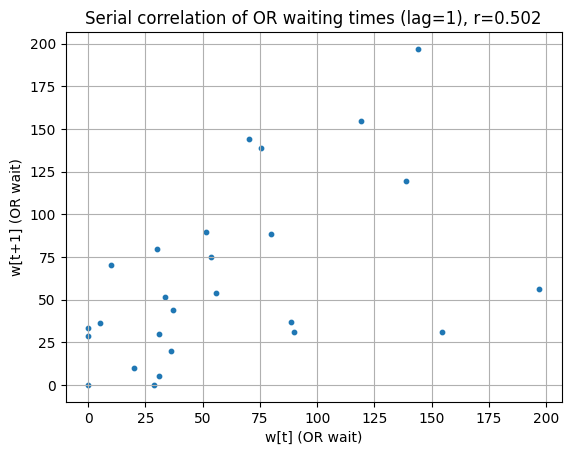

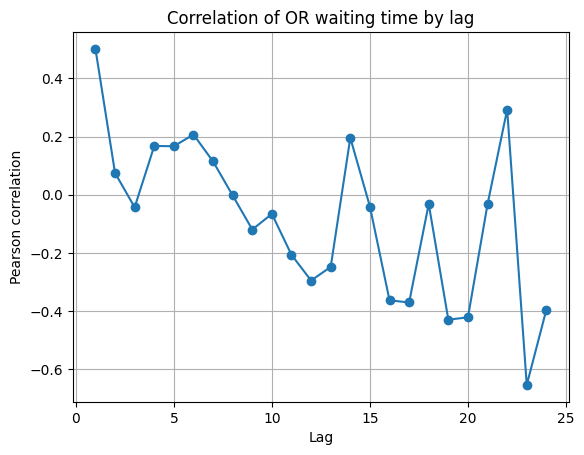

In [31]:
plotted_values = plot_wait_correlation(hospital.results, conf=hospital.conf, lag=1, max_lag=30, burn_in_time=0.0)

In [32]:
plotted_values

{'wait_series': array([  0.        ,   0.        ,  28.64586607,   0.        ,
         33.40030267,  51.63959547,  89.77964251,  30.8930097 ,
          5.35060686,  36.36545752,  20.14581643,   9.96507404,
         70.02566187, 143.98084695, 196.92314923,  56.01843553,
         53.82693183,  75.2503982 , 138.60470282, 119.26005872,
        154.71433822,  31.00059387,  29.96977943,  79.82398099,
         88.4848356 ,  37.13709018,  43.68117344]),
 'corr_lag': 0.5015206820100871,
 'corr_by_lag': [0.5015206820100871,
  0.07494273074466035,
  -0.04295767195821291,
  0.16788302359898127,
  0.1669310872776602,
  0.2071906626955956,
  0.11450998235756452,
  -0.002315788280764682,
  -0.11943890051489177,
  -0.06579608527562447,
  -0.2066019991396392,
  -0.2947737982609695,
  -0.24804409932873653,
  0.19588178114280805,
  -0.04036533920009733,
  -0.36277278603633056,
  -0.3703178472793826,
  -0.03157746994985706,
  -0.42952504285451565,
  -0.42128101280027047,
  -0.03258181848677803,
  0.29305